### Rapidly-Exploring Random Tree (RRT)

Your task is to generate an RRT based on the following pseudocode:

```
def generate_RRT(x_init, num_vertices, dt):
    rrt = RRT(x_init)
    for k in range(num_vertices):
        x_rand = sample_state()
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        # directed edge
        rrt.add_edge(x_near, x_new, u)
    return rrt
```
    
The `RRT` class has already been implemented. Your task is to complete the implementation of the following functions:

* `sample_state`
* `nearest_neighbor`
* `select_input`
* `new_state`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
filename='colliders.csv'
data=np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [44]:
class RRT:
    def __init__(self, x_init, goal):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
        #self.goal = goal
        
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_init))
        
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
        
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()

In [7]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

    return grid

In [8]:
drone_altitude=5
safe_distance=3
grid=create_grid(data, drone_altitude, safe_distance)
print(grid)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Sampling States

The first part of generating an RRT is sampling states based on the environment. The sampled state must be in free space. 

In [47]:
def sample_state(grid):
    x = np.random.uniform(0, grid.shape[0])
    y = np.random.uniform(0, grid.shape[1])
    return (x, y)

In [48]:
sample=sample_state(grid)
print(sample)

(273.0167908834639, 272.2516039438167)


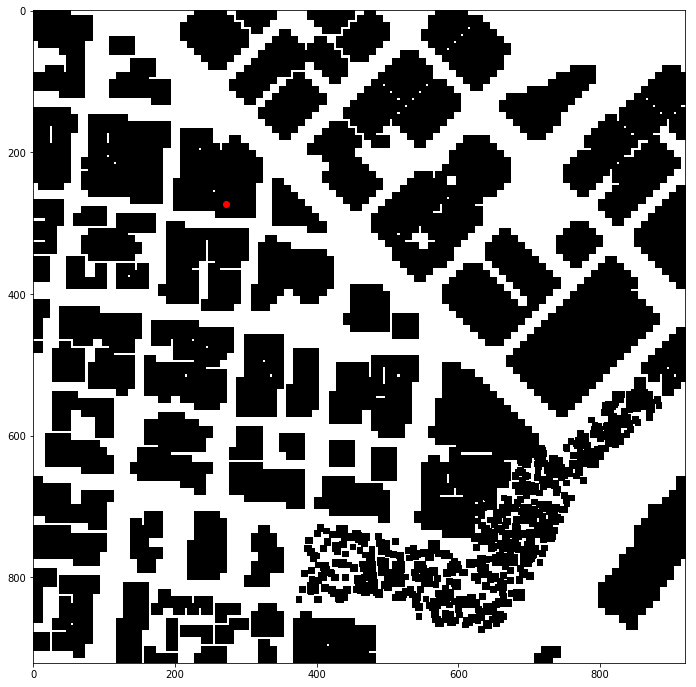

In [49]:
plt.imshow(grid, cmap='Greys', origin='upper')
plt.plot(sample[1], sample[0], 'ro')

#### Nearest Neighbors

A critical part of the RRT procedure is finding the closest vertex to the sampled random point. This the most computationally intensive part so be mindful of that. Depending on the number of vertices a naive implementation will run into trouble quickly.

In [50]:
def nearest_neighbor(x_rand, rrt):
    closest_dist = 100000
    closest_vertex = None
    x_rand = np.array(x_rand)
    
    for v in rrt.vertices:
        d = np.linalg.norm(x_rand - np.array(v[:2]))
        if d < closest_dist:
            closest_dist = d
            closest_vertex = v
    
    return closest_vertex

#### Selecting Inputs

Select input which moves `x_near` closer to `x_rand`. This should return the angle or orientation of the vehicle.

In [51]:
def select_input(x_rand, x_near):
    return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])

#### New State
The new vertex `x_new` is calculated by travelling from the current vertex `x_near` with a orientation `u` for time `dt`.


In [52]:
def new_state(x_near, u, dt):
    nx = x_near[0] + np.cos(u)*dt
    ny = x_near[1] + np.sin(u)*dt
    return [nx, ny]

#### Putting It All Together

Awesome! Now we'll put everything together and generate an RRT.

In [54]:
def generate_RRT(grid, x_init, goal, num_vertices, dt):
    
    rrt = RRT(x_init, goal)
    
    for _ in range(num_vertices):
        x_rand = sample_state(grid)
        # sample states until a free state is found
        while grid[int(x_rand[0]), int(x_rand[1])] == 1:
            x_rand = sample_state(grid)
            
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        
        if grid[int(x_new[0]), int(x_new[1])] == 0:
            # the orientation `u` will be added as metadata to
            # the edge
            rrt.add_edge(x_near, x_new, u)
            
    return rrt        

Feel free to change any of the values below.

In [55]:
num_vertices = 12000
dt = 2
x_init = (20, 105)
goal=(750, 370)
rrt = generate_RRT(grid, x_init, goal, num_vertices, dt)
print(rrt)

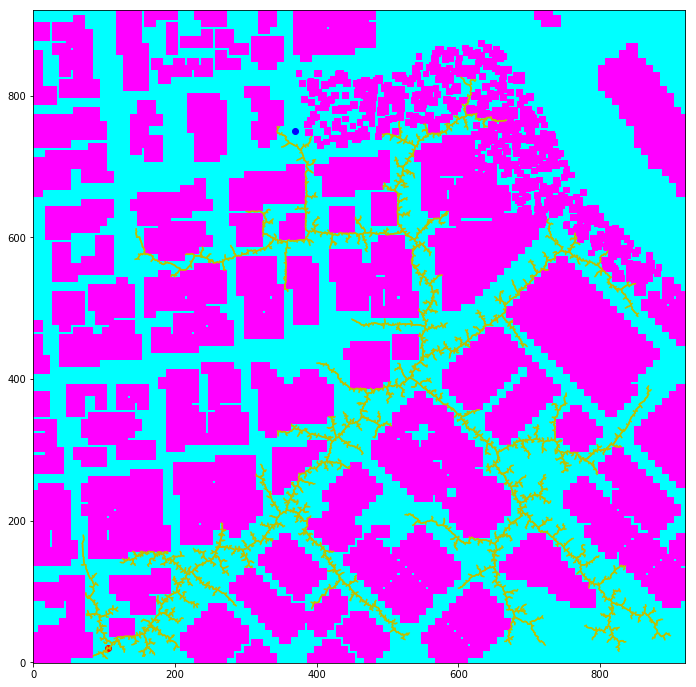

In [56]:
plt.imshow(grid, cmap='cool', origin='lower')
plt.plot(x_init[1], x_init[0], 'ro')
plt.plot(goal[1], goal[0], 'bo')

for (e1, e2) in rrt.edges:
    plt.plot([e1[1], e2[1]], [e1[0], e2[0]], 'y-')
    

    
plt.show()

In [1]:
from RRTs import RRTPlanner
from __future__ import division
from shapely.geometry import Polygon
from environment import Environment
from RRTs import RRTPlanner
from matplotlib import pyplot as plt

In [72]:
environment = Environment('bugtrap.yaml')
bounds = (-2, -3, 12, 8)
start_pose = (2, 2.5)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
object_radius = 0.3
steer_distance = 0.3
num_iterations = 10000
resolution = 3
drawResults = True
runForFullIterations = False

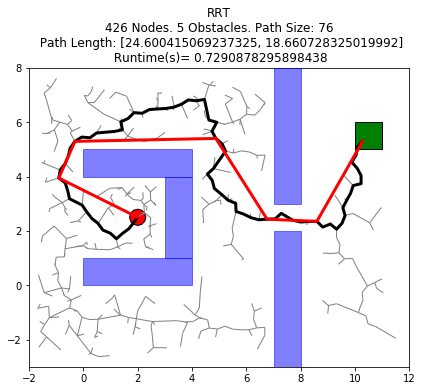

In [76]:
rr = RRTPlanner()
path=rr.RRT(environment, bounds, start_pose, goal_region, object_radius, steer_distance, num_iterations, resolution, drawResults, runForFullIterations)
plt.show()

In [11]:
environment = grid
bounds = (-2, -3, 12, 8)
start_pose = (2, 2.5)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
object_radius = 0.3
steer_distance = 0.3
num_iterations = 10000
resolution = 3
drawResults = True
runForFullIterations = False

In [3]:
#rr = RRTPlanner()
#path=rr.RRT(environment, bounds, start_pose, goal_region, object_radius, steer_distance, num_iterations, resolution, drawResults, runForFullIterations)
#plt.show()

In [62]:
print(RRT)

In [58]:
import sys
!{sys.executable} -m pip install -I shapely==1.6

    100% |████████████████████████████████| 215kB 131kB/s ta 0:00:01
  Running setup.py bdist_wheel for shapely ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/2a/ac/7c/ea6b32517c7c748d762545a7cbf2e3191dda4be38974b46f79
Successfully built shapely


In [65]:
import sys
!{sys.executable} -m pip install -I cartopy

    100% |████████████████████████████████| 8.9MB 40kB/s ta 0:00:011
  Installing build dependencies ... done
  Using cached https://files.pythonhosted.org/packages/88/a1/e3aaf62d35353d6fa0abe9c4044edf536470a28fc56c633e3efa859aa8dd/numpy-1.15.4-cp35-cp35m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
    100% |████████████████████████████████| 1.6MB 44kB/s ta 0:00:018
    100% |████████████████████████████████| 215kB 43kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/37/06/754589caf971b0d2d48f151c2586f62902d93dc908e2fd9b9b9f6aa3c9dd/setuptools-40.6.3-py2.py3-none-any.whl
  Running setup.py bdist_wheel for cartopy ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/cd/cf/40/539f798f94e921e94fd376a5f9d213a6febe77754c0b187c73
  Running setup.py bdist_wheel for pyshp ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/cc/e8/7c/f00fc95ae2a16ed41be9defdd647213a334fd12e03b14

start RRT path planning
aaa


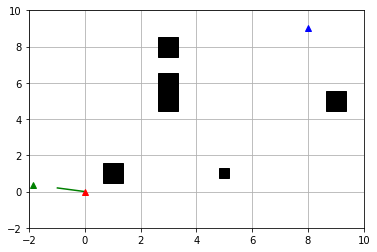

aaa


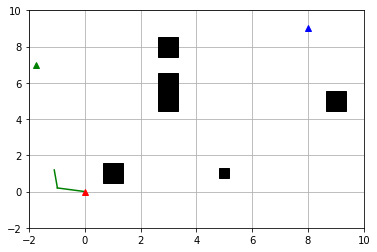

aaa


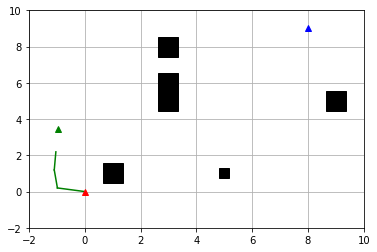

aaa


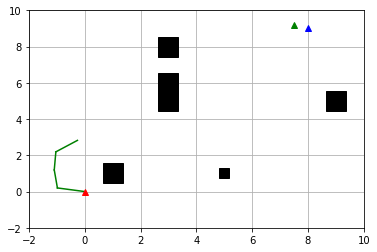

aaa


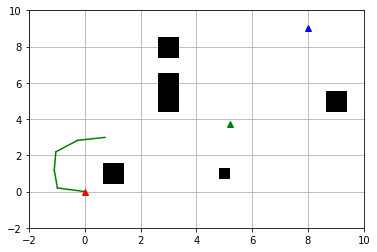

aaa


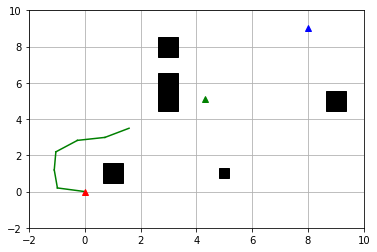

aaa


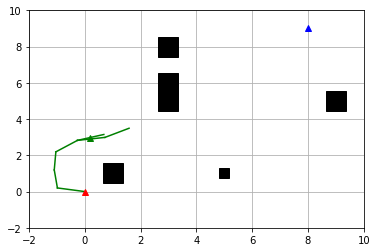

aaa


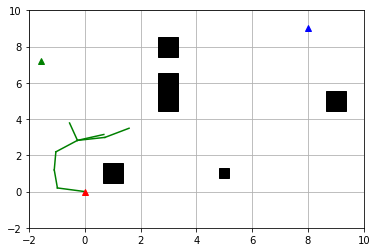

aaa


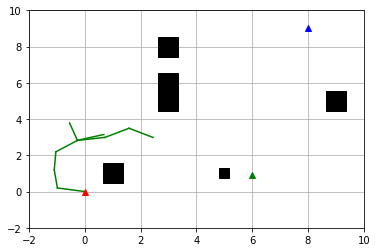

aaa


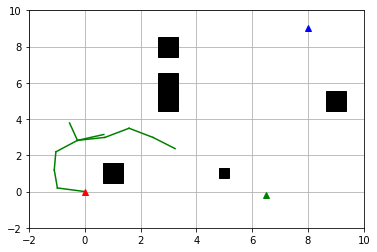

aaa


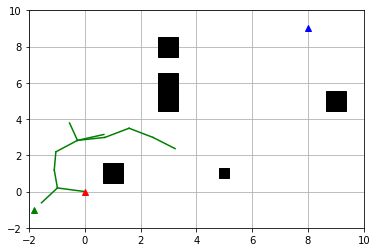

aaa


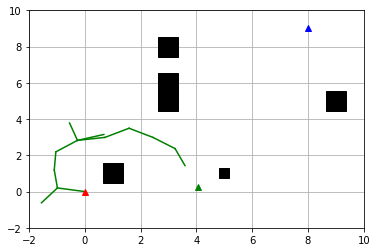

aaa


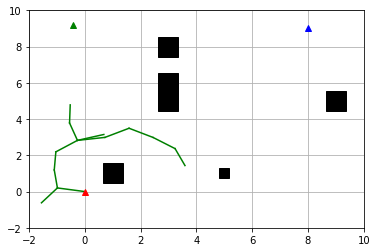

aaa


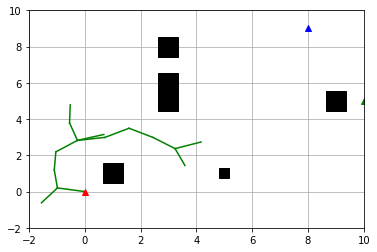

aaa


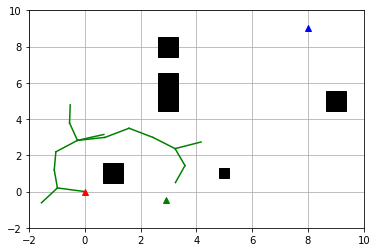

aaa


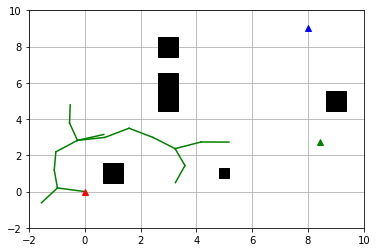

aaa


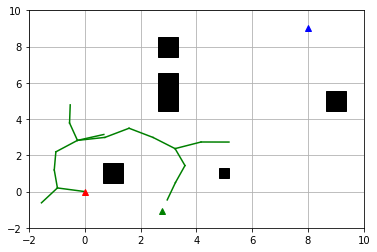

aaa


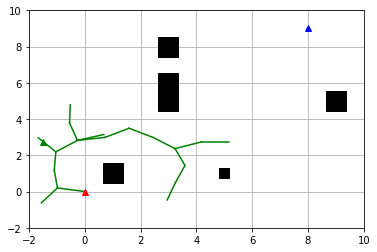

aaa


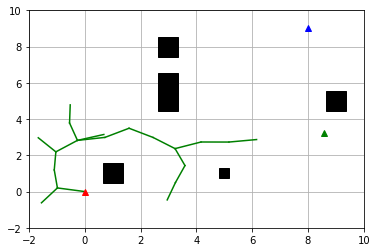

aaa


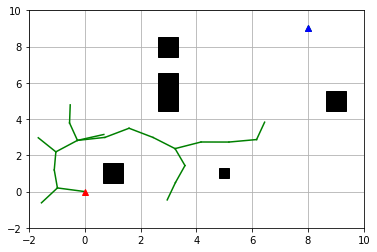

aaa


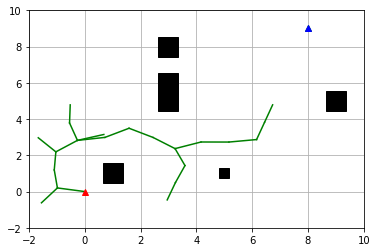

aaa


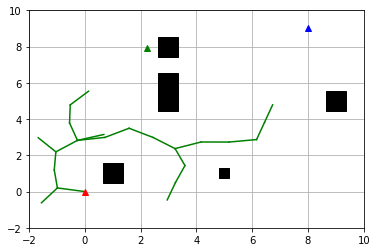

aaa


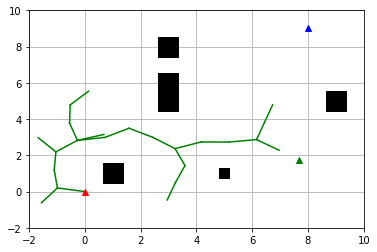

aaa


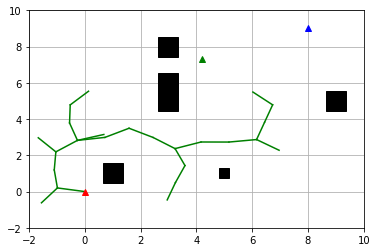

aaa


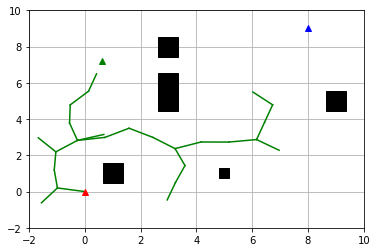

aaa


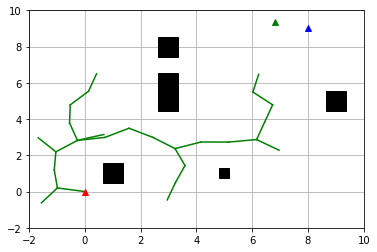

aaa


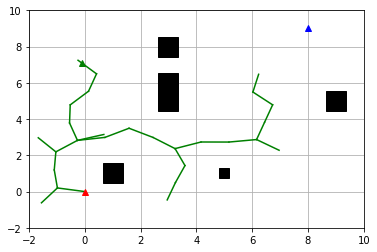

aaa


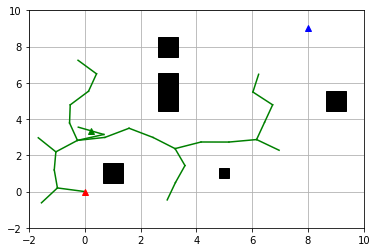

aaa


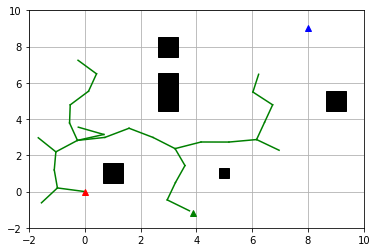

aaa


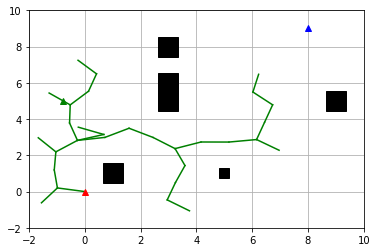

aaa


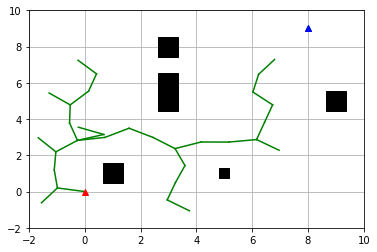

aaa


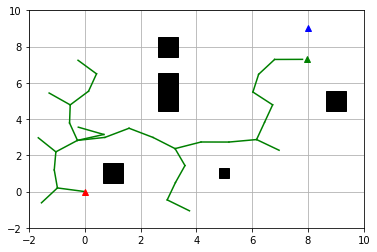

aaa


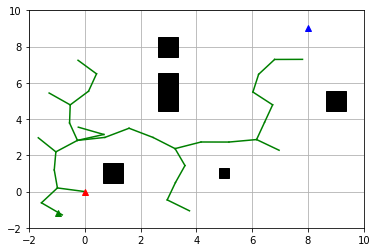

aaa


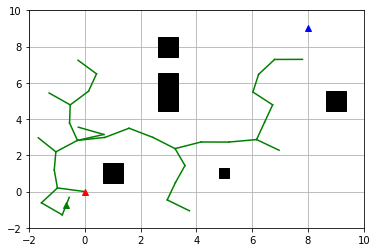

aaa


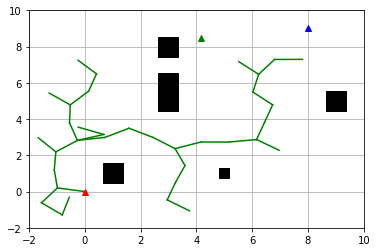

aaa


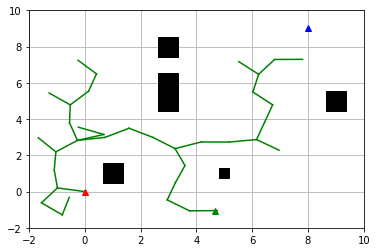

aaa


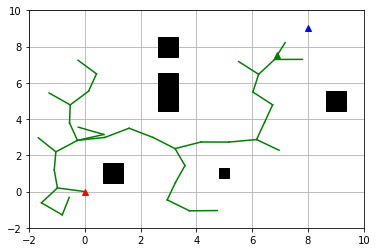

aaa


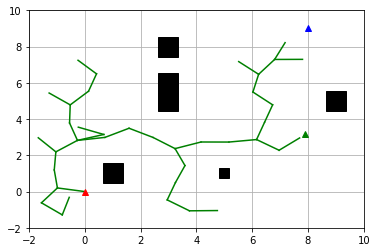

aaa


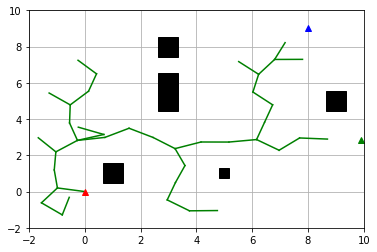

aaa


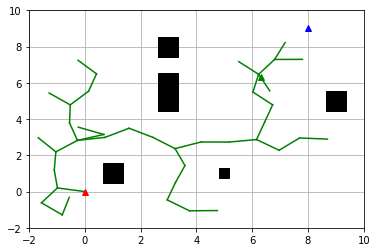

aaa


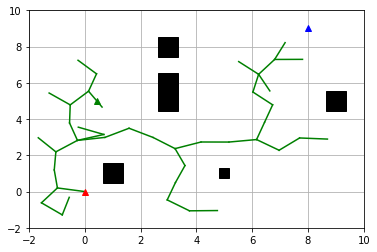

aaa


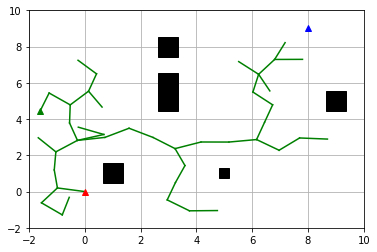

Goal!!
[[8, 9], [7.924262187550371, 8.886342616286], [7.180814296486163, 8.217548751726687], [6.805228225656863, 7.290761233792287], [6.232311618867978, 6.471147567687633], [6.026816241078812, 5.492489481476065], [6.734048469626563, 4.785508169910207], [6.446366199597076, 3.8277822636558745], [6.158683929567589, 2.8700563574015425], [5.168230859580665, 2.732206017708539], [4.168235415363785, 2.7352245513734594], [3.2373056160896283, 2.3700263739089786], [2.4494110470512727, 2.985836529784849], [1.5881144689600992, 3.493939082984924], [0.7247833325028795, 2.9893012437145363], [-0.26159263201493077, 2.8247945367948506], [-1.0355064231888558, 2.1915035737843223], [-1.0930694513039634, 1.1931616995777858], [-0.979879846260142, 0.199588293477349], [0, 0]]


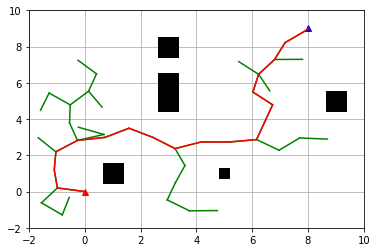

In [2]:
import matplotlib.pyplot as plt
import random
import math
import copy

show_animation = True


class Node(object):
    """
    RRT Node
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None


class RRT(object):
    """
    Class for RRT Planning
    """

    def __init__(self, start, goal, obstacle_list, rand_area):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:random sampling Area [min,max]

        """
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expandDis = 1.0
        self.goalSampleRate = 0.05  # 选择终点的概率是0.05
        self.maxIter = 500
        self.obstacleList = obstacle_list
        self.nodeList = [self.start]

    def random_node(self):
        """
        产生随机节点
        :return:
        """
        node_x = random.uniform(self.min_rand, self.max_rand)
        node_y = random.uniform(self.min_rand, self.max_rand)
        node = [node_x, node_y]

        return node

    @staticmethod
    def get_nearest_list_index(node_list, rnd):
        """
        :param node_list:
        :param rnd:
        :return:
        """
        d_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        min_index = d_list.index(min(d_list))
        return min_index

    @staticmethod
    def collision_check(new_node, obstacle_list):
        a = 1
        for (ox, oy, size) in obstacle_list:
            dx = ox - new_node.x
            dy = oy - new_node.y
            d = math.sqrt(dx * dx + dy * dy)
            if d <= size:
                a = 0  # collision

        return a  # safe

    def planning(self):
        """
        Path planning

        animation: flag for animation on or off
        """

        while True:
            # Random Sampling
            if random.random() > self.goalSampleRate:
                rnd = self.random_node()
            else:
                rnd = [self.end.x, self.end.y]

            # Find nearest node
            min_index = self.get_nearest_list_index(self.nodeList, rnd)
            # print(min_index)

            # expand tree
            nearest_node = self.nodeList[min_index]

            # 返回弧度制
            theta = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)

            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expandDis * math.cos(theta)
            new_node.y += self.expandDis * math.sin(theta)
            new_node.parent = min_index

            if not self.collision_check(new_node, self.obstacleList):
                continue

            self.nodeList.append(new_node)

            # check goal
            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx * dx + dy * dy)
            if d <= self.expandDis:
                print("Goal!!")
                break

            if True:
                self.draw_graph(rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.nodeList) - 1
        while self.nodeList[last_index].parent is not None:
            node = self.nodeList[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        return path

    def draw_graph(self, rnd=None):
        """
        Draw Graph
        """
        print('aaa')
        plt.clf()  # 清除上次画的图
        if rnd is not None:
            plt.plot(rnd[0], rnd[1], "^g")
        for node in self.nodeList:
            if node.parent is not None:
                plt.plot([node.x, self.nodeList[node.parent].x], [
                         node.y, self.nodeList[node.parent].y], "-g")

        for (ox, oy, size) in self.obstacleList:
            plt.plot(ox, oy, "sk", ms=10*size)

        plt.plot(self.start.x, self.start.y, "^r")
        plt.plot(self.end.x, self.end.y, "^b")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])
        plt.grid(True)
        plt.pause(0.01)

    def draw_static(self, path):
        """
        画出静态图像
        :return:
        """
        plt.clf()  # 清除上次画的图

        for node in self.nodeList:
            if node.parent is not None:
                plt.plot([node.x, self.nodeList[node.parent].x], [
                    node.y, self.nodeList[node.parent].y], "-g")

        for (ox, oy, size) in self.obstacleList:
            plt.plot(ox, oy, "sk", ms=10*size)

        plt.plot(self.start.x, self.start.y, "^r")
        plt.plot(self.end.x, self.end.y, "^b")
        plt.axis([self.min_rand, self.max_rand, self.min_rand, self.max_rand])

        plt.plot([data[0] for data in path], [data[1] for data in path], '-r')
        plt.grid(True)
        plt.show()


def main():
    print("start RRT path planning")
    #filename='colliders.csv'
    #data=np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
    #obstacle_list=create_grid(data, drone_altitude, safe_distance)
    #print(obstacle_list)
    obstacle_list = [
        (5, 1, 1),
        (3, 6, 2),
        (3, 8, 2),
        (1, 1, 2),
        (3, 5, 2),
        (9, 5, 2)]

    # Set Initial parameters
    rrt = RRT(start=[0, 0], goal=[8, 9], rand_area=[-2, 10], obstacle_list=obstacle_list)
    path = rrt.planning()
    print(path)

    # Draw final path
    if show_animation:
        plt.close()
        rrt.draw_static(path)


if __name__ == '__main__':
    main()